# Linear Mixed Model

When we have data that is grouped or somehow correlated and want to use regression to model the data, one may attempt the following:

- run one regression model (eg what we would do anyways); this approach breaks the IID assumption and underestimates the standard error variance
- run multiple regression models (eg run a regression for each cluster of grouped/non-IID data); this approach increases the chances of Type I error (multiple comparison) and uses a reduced data set for each regression

Linear mixed modeling `LMM` is a type of regression modeling approach that accounts for the violation of non-IID (independently and identically distributed) data and is a balance between the two approaches above. The problem of non-IID data is that using ordinary regression may underestimate the variance (standard error) of the parameter estimations and lead to incorrect hypothesis testing as well as a model that is no longer the Best Linear Unbiased Estimator `BLUE`. Additionally, LMM are useful for understanding within and between group differences.

There are many ways to combat non-IID:

- get a better model (eg use multilevel or linear mixed models)
- get a better variance estimator (eg Huber sandwich estimator)
- sample the data (eg Iteratively Reweighting Least Square)

In this notebook, we will focus on LMM and two ways to estimate the standard errors using maximum likelihood `ML` and restricted maximum likelihood `REML`. It should be noted that multilevel models are a type of LMM, but not all LMMs are multilevel. A LMM is denoted as follows, 

- $Y = X \beta + Z u + e$,

where

- $\beta$ are the coefficients (intercept and slope),
- $X$ is the design matrix (independent variables) of dimension $N$ x $M$ ($N$ rows and $M$ columns),
- $Z$ is a sparse indicator matrix of the group (of each observation in $X$) of dimension $N$ x $J$ ($N$ rows and $J$ columns),
- $u$ and $e$ are the error terms corresponding to $X$ and $Z$, respectively, and
- $Y$ is the dependent variable.

Note that $u$ and $e$ are column vectors assumed to be normally distributed with zero means and covariance $G$ and $R$ as follows,

$\begin{pmatrix} u \\ e \end{pmatrix} \sim \mathcal{N} \begin{pmatrix} \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} G & 0 \\ 0 & R \end{pmatrix} \end{pmatrix}$

where

- $G_{JxJ} = I \sigma^2_{\mathrm{group}}$, and
- $R_{NxN} = I \sigma^2_{\mathrm{residual}}$.

For clarity, 

- $u \sim \mathcal{N}(0, G)$, and
- $e \sim \mathcal{N}(0, R)$.

The variables in $X$ are said to be `fixed effects` and the grouping variables in $Z$ are said to be the `random effects`. Grouping variables are categorical and can be quite complex in their relationship to one another. Grouping variables can be 

- nested (when the groups exists within other groups eg patients are observed only within a single hospital),
- partially crossed (when some groups are seen with others eg some patients are observed across some hospitals), or
- crossed (when all groups are seen with all other groups eg all patients are observed across all hospitals).

In mature LMM packages (e.g. [lme4](https://cran.r-project.org/web/packages/lme4/index.html)), these types of grouping relationships are easily expressed. The mixture of fixed and random effects is the `mixed` in linear mixed models `LMM`. 

In probability form, a LMM can be written as follows.

- $P(Y|\beta; u) \sim \mathcal{N}(X \beta + Z u, R)$

In a multilevel model, when we allow for the intercept to vary, a LMM can be written as follows.

- L1: $Y_{ij} = \beta_{0j} + \beta_{1j} X_{ij} + \ldots + \beta_{mj} X_{mj} + e_{ij}$,
- L2: $\beta_{0j} = \gamma_{00} + u_{0j}$,
- L2: $\beta_{1j} = \gamma_{10}$,
- $\dots$,
- L2: $\beta_{mj} = \gamma_{mj}$,

where

- L1 is the Level 1 model (micro-model) of the individual units (e.g. student, patient),
- L2 is a Level 2 model (macro-model) of the grouped/clustered units (e.g. teacher, hospital),
- $Y_{ij}$ is the value of the dependent variable for i-th individual and the j-th group,
- $\beta_{0j}$ is the intercept for the j-th group,
- $\beta_{1j}, \ldots, \beta_{mj}$ are the coefficients for the j-th group, and
- $e_{ij}$ is the error for the i-th individual for the j-th group.

Notice how the intercept $\beta_{0j}$ is the only parameter we allow to vary at `L2` (it is the only parameter at `L2` that has an error term). If we allow the other parameters to vary at `L2` (have error terms), then the multilevel model is said to be a random-intercept, random-slope multilevel model.

## Data

This data is take from a [Littell 2006](https://www.amazon.com/Mixed-Models-Second-Ramon-Littell/dp/1590475003). In this data, we have 7 ingots, 3 metal types  and 1 dependent variable. 

In [1]:
import pandas as pd
import itertools

df = pd.DataFrame({
    'ingot': itertools.chain(*[[i + 1 for _ in range(3)] for i in range(7)]),
    'metal': ['n', 'i', 'c'] * 7,
    'pres': [67,71.9,72.2,67.5,68.8,66.4,76,82.6,74.5,72.7,78.1,67.3,73.1,74.2,73.2,65.8,70.8,68.7,75.6,84.9,69]
}).assign(
    ingot_1=lambda d: d['ingot'].apply(lambda i: 1 if i == 1 else 0),
    ingot_2=lambda d: d['ingot'].apply(lambda i: 1 if i == 2 else 0),
    ingot_3=lambda d: d['ingot'].apply(lambda i: 1 if i == 3 else 0),
    ingot_4=lambda d: d['ingot'].apply(lambda i: 1 if i == 4 else 0),
    ingot_5=lambda d: d['ingot'].apply(lambda i: 1 if i == 5 else 0),
    ingot_6=lambda d: d['ingot'].apply(lambda i: 1 if i == 6 else 0),
    ingot_7=lambda d: d['ingot'].apply(lambda i: 1 if i == 7 else 0)
)

df

,ingot,metal,pres,ingot_1,ingot_2,ingot_3,ingot_4,ingot_5,ingot_6,ingot_7
0,1,n,67.0,1,0,0,0,0,0,0
1,1,i,71.9,1,0,0,0,0,0,0
2,1,c,72.2,1,0,0,0,0,0,0
3,2,n,67.5,0,1,0,0,0,0,0
4,2,i,68.8,0,1,0,0,0,0,0
5,2,c,66.4,0,1,0,0,0,0,0
6,3,n,76.0,0,0,1,0,0,0,0
7,3,i,82.6,0,0,1,0,0,0,0
8,3,c,74.5,0,0,1,0,0,0,0
9,4,n,72.7,0,0,0,1,0,0,0


## Linear regression

In [2]:
from patsy import dmatrices, dmatrix
import numpy as np
from sklearn.linear_model import LinearRegression

f = 'pres ~ metal'
y, X = dmatrices(f, df, return_type='dataframe')
X = X.iloc[:,1:]
y = np.ravel(y)

X.shape, y.shape

model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(70.1857142857143, array([5.71428571, 0.91428571]))

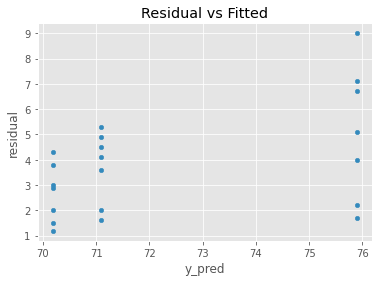

In [3]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

_ = pd.DataFrame({
    'y': y,
    'y_pred': model.predict(X)
}).assign(residual=lambda d: np.abs(d['y'] - d['y_pred'])) \
.plot(kind='scatter', x='y_pred', y='residual', title='Residual vs Fitted')

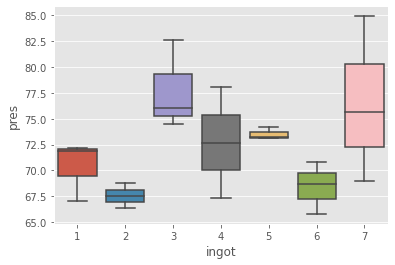

In [4]:
import seaborn as sns

_ = sns.boxplot(x='ingot', y='pres', data=df)

Just for fun, let's use a multilevel model using the `intercept method`. In the intercept method, we regress the dependent variable on the independent ones as well the dummy encoded grouping variable (we have 7 dummy variables and we drop the first and use it as the reference) at L1. We then use the coefficients associated with the dummy variables as the dependent variables to be regressed on at L2.

The L1 model is given as follows. Look at the intercept and first 2 coefficients, they are nearly identical to the OLS model above.

- L1: $Y_{ij} = \beta_{0j} + \beta_{1j} \mathrm{metal}_{1j} + \beta_{2j} \mathrm{ingot}_{i2} + \beta_{3j} \mathrm{ingot}_{i3} + \beta_{4j} \mathrm{ingot}_{i4} + \beta_{5j} \mathrm{ingot}_{i5} + \beta_{6j} \mathrm{ingot}_{i6} + \beta_{7j} \mathrm{ingot}_{i7} + e_{ij}$

In [5]:
f = 'pres ~ metal + C(ingot)'
y, X = dmatrices(f, df, return_type='dataframe')
X = X.iloc[:,1:]
y = np.ravel(y)

model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(68.15714285714286,
 array([ 5.71428571,  0.91428571, -2.8       ,  7.33333333,  2.33333333,
         3.13333333, -1.93333333,  6.13333333]))

The L2 model is given as follows.

- L2: $\beta_{0j} = \gamma_{00} + u_{0j}$,
- L2: $\beta_{2j} = \gamma_{20} + u_{2j}$,
- $\ldots$
- L2: $\beta_{7j} = \gamma_{70} + u_{7j}$,

In [6]:
y = np.ravel(model.coef_[2:])
y = np.array([0] + list(model.intercept_ - y))

X = dmatrix('+'.join([f'ingot_{i}' for i in range(2, 8)]), df, return_type='dataframe')
X = X.iloc[:,1:].drop_duplicates().values

X, y, X.shape, y.shape

model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(0.0,
 array([70.95714286, 60.82380952, 65.82380952, 65.02380952, 70.09047619,
        62.02380952]))

## LMM via ML

Let's estimate the standard error using the ML approach. Denote the following.

- $V = Z G Z^T + R$
- $B = (X^T V^{-1} X)^{-1} X^T V^{-1} Y$

Then, the likelihood function to be optimized is written as follows.

- $-2 L_{\mathrm{ML}}(\theta; Y) = \log |V| + (Y - X B_{\theta})^T V^{-1} (Y - X B_{\theta})$

In [7]:
from patsy import dmatrices, dmatrix

f = 'pres ~ metal'
y, X = dmatrices(f, df, return_type='dataframe')

f = ' + '.join([f'ingot_{i+1}' for i in range(7)]) + ' - 1'
Z = dmatrix(f, df, return_type='dataframe')

y = y.values
X = X.values
Z = Z.values

The standard error and residual are estimated as follows.

In [8]:
from scipy.optimize import minimize
import numpy as np

def log_ml(x):
    G = x[0] * np.diag(np.ones(7))
    R = x[1] * np.diag(np.ones(21))
    V = Z.dot(G).dot(Z.T) + R
    V_inv = np.linalg.inv(V)
    X_T = X.T
    B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
    LL = np.log(np.linalg.det(V)) + (y - (X.dot(B))).T.dot(V_inv).dot(y - (X.dot(B)))
    
    return np.ravel(LL)[0]

r = minimize(fun=log_ml, x0=np.array([1, 1]), method='Nelder-Mead', tol=0.0000000000001, options={'maxiter': 500})
r

 final_simplex: (array([[9.81238077, 8.88993185],
       [9.81238077, 8.88993185],
       [9.81238077, 8.88993185]]), array([77.11196749, 77.11196749, 77.11196749]))
           fun: 77.11196749090402
       message: 'Optimization terminated successfully.'
          nfev: 253
           nit: 109
        status: 0
       success: True
             x: array([9.81238077, 8.88993185])

The coefficients are estimated as follows.

In [9]:
def hat_beta(x):
    G = x[0] * np.diag(np.ones(7))
    R = x[1] * np.diag(np.ones(21))
    V = Z.dot(G).dot(Z.T) + R
    V_inv = np.linalg.inv(V)
    X_T = X.T
    B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
    
    return np.ravel(B)

hat_beta(r.x)

array([70.18571429,  5.71428571,  0.91428571])

## LMM via REML

The likelihood function to be optimized with REML is as follows.

- $-2 L_{\mathrm{REML}}(\theta; Y) = \log |V| + \log |X^T V^{-1} X| + (Y - X B_{\theta})^T V^{-1} (Y - X B_{\theta})$

Note that the standard error and residual is larger than with the ML approach.

In [10]:
def log_reml(x):
    G = x[0] * np.diag(np.ones(7))
    R = x[1] * np.diag(np.ones(21))
    V = Z.dot(G).dot(Z.T) + R
    V_inv = np.linalg.inv(V)
    X_T = X.T
    B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
    LL = np.log(np.linalg.det(V)) + np.log(np.linalg.det(X.T.dot(V_inv).dot(X))) + (y - (X.dot(B))).T.dot(V_inv).dot(y - (X.dot(B)))
    
    return np.ravel(LL)[0]

r = minimize(fun=log_reml, x0=np.array([1, 1]), method='Nelder-Mead', tol=0.0000000000001, options={'maxiter': 500})
r

 final_simplex: (array([[11.44777794, 10.37158691],
       [11.44777794, 10.37158691],
       [11.44777794, 10.37158691]]), array([74.70841482, 74.70841482, 74.70841482]))
           fun: 74.7084148191172
       message: 'Optimization terminated successfully.'
          nfev: 244
           nit: 107
        status: 0
       success: True
             x: array([11.44777794, 10.37158691])

In [11]:
hat_beta(r.x)

array([70.18571429,  5.71428571,  0.91428571])

## LMM via statsmodels

We can verify the REML approach with `statsmodels`.

In [12]:
import statsmodels.formula.api as smf

m = smf.mixedlm('pres ~ metal', df, groups=df['ingot'])
m = m.fit(method=['lbfgs'])

print(m.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pres    
No. Observations: 21      Method:             REML    
No. Groups:       7       Scale:              10.3716 
Min. group size:  3       Log-Likelihood:     -53.8951
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   70.186    1.766 39.754 0.000 66.725 73.646
metal[T.i]   5.714    1.721  3.320 0.001  2.340  9.088
metal[T.n]   0.914    1.721  0.531 0.595 -2.460  4.288
Group Var   11.448    3.273                           



## LMM via pymer4

You will have to have `R` installed with the following packages, [lme4](https://cran.r-project.org/web/packages/lme4/index.html) and [lmerTest](https://cran.r-project.org/web/packages/lmerTest/index.html), as [pymer4](https://github.com/ejolly/pymer4) uses [rpy2](https://rpy2.github.io/) to use `R` to do the estimations.

In [13]:
from pymer4.models import Lmer

m = Lmer('pres ~ metal + (1 | ingot)', data=df)

In [14]:
m.fit()

Formula: pres~metal+(1|ingot)

Family: gaussian	 Inference: parametric

Number of observations: 21	 Groups: {'ingot': 7.0}

Log-likelihood: -53.895 	 AIC: 107.790

Random effects:

                 Name     Var    Std
ingot     (Intercept)  11.448  3.383
Residual               10.372  3.220

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),70.186,66.725,73.646,1.766,11.609,39.754,0.000,***
metali,5.714,2.340,9.088,1.721,12.000,3.320,0.006,**
metaln,0.914,-2.460,4.288,1.721,12.000,0.531,0.605,


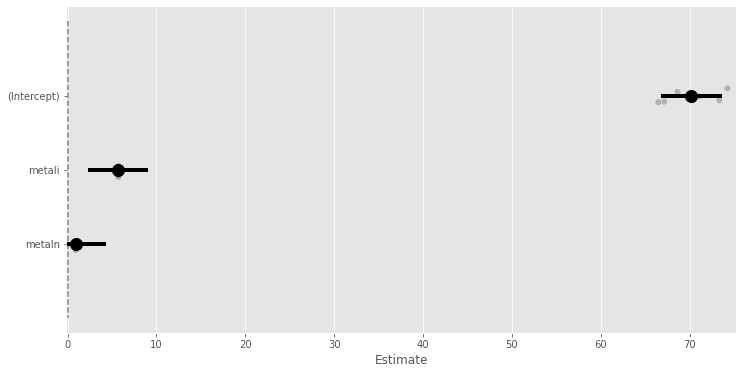

In [15]:
_ = m.plot_summary()